## Code reference:
* News scraping
    - DataNews documentation: https://datanews.io/docs/news

* VADER: 
    - https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [1]:
# Import modules
import newspaper
from newspaper import Article
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import datetime as dt

from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
import backtrader.indicators as btind

import os.path
import sys

import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

import matplotlib.pyplot as plt

import yfinance as yf

import inspect
import datanews

# News scraping

In [2]:
# API setup
query = "Facebook"
ticker = "FB"
from_date = "2021-03-12T09:30:00+00:00"
to_date = "2021-03-12T15:59:00+00:00"
sortBy = "date"
source = "marketwatch.com"
topic = "business"
apiKey = "4dbc17e007ab436fb66416009dfb59a8"

In [3]:
# Get the news
datanews.api_key = '0bnmoy3ll9lyxacrjlttep15n'
response = datanews.news(q = query,
                         from_date = from_date,
                         to_date = to_date,
                         country = ['us'],
                         language = ['en'],
                         topic = topic,
                         sortBy = sortBy,
                         #source = source,
                         size=100)

In [4]:
# Turn the news into dataframe
articles = response['hits']
df = pd.DataFrame(articles)

In [5]:
df.head()

,url,source,authors,title,pubDate,country,language,description,imageUrl,content
0,https://www.businessinsider.com/facebook-diver...,businessinsider.com,[Maxine Williams],Facebook Diversity Chief speaks out on anti-As...,2021-03-12T15:46:48+00:00,us,en,Facebook Diversity Chief speaks out on anti-As...,https://i.insider.com/604924469942cf001865da4a...,\n• Violence against Asian Americans is on the...
1,https://www.ibtimes.com/sri-lanka-bristles-ove...,ibtimes.com,[AFP News],Sri Lanka Bristles Over Chinese Doormats Featu...,2021-03-12T15:45:24+00:00,us,en,Sri Lanka bristles over Chinese doormats featu...,https://s1.ibtimes.com/sites/www.ibtimes.com/f...,Sri Lanka has complained to Beijing over Chine...
2,https://www.entrepreneur.com/article/365804,entrepreneur.com,[Clair Kim],Unconventional Ways to Source Diverse Talent,2021-03-12T15:00:00+00:00,us,en,Unconventional Ways to Source Diverse Talent ...,https://assets.entrepreneur.com/content/3x2/20...,Opinions expressed by Entrepreneur contributor...
3,https://au.finance.yahoo.com/news/costco-may-b...,au.finance.yahoo.com,[Brian Sozzi],Costco may be 'poised' to increase membership ...,2021-03-12T14:27:49+00:00,us,en,Costco may be 'poised' to increase membership ...,https://s.yimg.com/ny/api/res/1.2/NCBbtBJ5MeDI...,Costco (COST) may be about to put the burden o...
4,https://www.reuters.com/article/india-media-re...,reuters.com,[Sankalp Phartiyal],India's digital media regulation sparks fears ...,2021-03-12T14:21:00+00:00,us,en,India's digital media regulation sparks fears ...,https://static.reuters.com/resources/r/?m=02&d...,NEW DELHI (Reuters) - India’s new oversight of...


# VADER analysis

In [6]:
# Generate sentiment scores
df['scores'] = df['content'].apply(lambda review:sid.polarity_scores(review))
df['compound']  = df['scores'].apply(lambda score_dict:score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
df[['compound']].head()

,compound
0,-0.8481
1,-0.2500
2,0.2023
3,-0.0772
4,0.0000


# Combine with stock market

In [7]:
# Download stock data from yahoo finance
data = yf.download(ticker, period = '1d', interval = "1m")
# data = yf.download(ticker, start="2021-03-13", end="2021-03-13", interval = "1m")
# data = data.append(yf.download(ticker, start="2021-03-08", end="2021-03-13", interval = "1m"))
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-03-12 09:30:00-05:00,268.680115,269.049988,268.680115,268.680115,268.680115,616773
2021-03-12 09:31:00-05:00,268.820007,268.829987,267.029999,267.910004,267.910004,147236
2021-03-12 09:32:00-05:00,267.890015,268.184998,267.489990,267.869995,267.869995,149165
2021-03-12 09:33:00-05:00,268.290009,268.369995,267.929993,268.119995,268.119995,147121
2021-03-12 09:34:00-05:00,268.000000,268.179993,267.890015,267.994995,267.994995,99214


In [15]:
# Experiment:
data['Adj Close'] = data['Adj Close']-data['Adj Close'].shift(1)

In [16]:
# Make publish time the index
df['time'] = pd.to_datetime(df['pubDate'])
df['time'] = df['time'].dt.floor('Min')
df['time'] = df['time'].dt.tz_localize(None)
df = df.set_index('time')

In [17]:
# Make timestamp the index 
data['Time'] = data.index
data['Time'] = data['Time'].dt.tz_localize(None)
data = data.set_index('Time')

In [18]:
# Inspect the duplicating sentiment scores
df['Duplicated'] = df.index.duplicated()
len(df[df['Duplicated']==True]['Duplicated'])

0

In [19]:
# Combine the stock figure and duplication compounded sentiment scores
result = pd.DataFrame()
result["Stock"] = data['Adj Close']
result["Sentiment"] = df.reset_index().pivot_table(columns=["time"]).T['compound']
result.head()

,Stock,Sentiment
Time,,
2021-03-12 09:30:00,NaN,NaN
2021-03-12 09:31:00,-0.770111,NaN
2021-03-12 09:32:00,-0.040009,NaN
2021-03-12 09:33:00,0.250000,NaN
2021-03-12 09:34:00,-0.125000,NaN


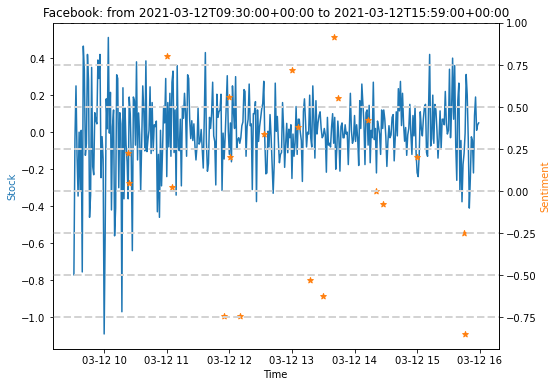

In [20]:
# Plot the figure
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax2.grid(color='lightgrey', linestyle='--', linewidth=2)

ax1.plot(result["Stock"],color = 'tab:blue')
ax2.scatter(x = result.index, y = result["Sentiment"], color = 'tab:orange', marker = "*")

ax1.set_xlabel('Time')
ax1.set_ylabel('Stock', color='tab:blue')
ax2.set_ylabel('Sentiment', color='tab:orange')


plt.title('{q}: from {f} to {t}'.format(q=query,f=from_date, t=to_date))

plt.title('{q}: from {f} to {t}'.format(q=query,f=from_date, t=to_date))
plt.savefig('Results/{q} {t}.png'.format(q=query, t=topic))

plt.show()

In [13]:
df["url"][0
         ]

'https://www.businessinsider.com/facebook-diversity-chief-anti-asian-violence-covid-19-hate-crime2021-3'